# Serve Llama2-7b on SageMaker using the LMI container.


In this notebook, we deploy the [llama2-7B](https://huggingface.co/TheBloke/Llama-2-7b-fp16) model on SageMaker by leveraging the [SageMaker Large Model Inference Container](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers). For the purpose of this notebook, we'll use the weights from the following source:
- https://huggingface.co/TheBloke/Llama-2-7B-Chat-fp16

However, you can use the same approach to deploy the model using any other Llama2 weights like https://huggingface.co/TheBloke/Llama-2-7B-Chat-fp16, etc.

For information on llama2, please refer the paper [Llama 2: Open Foundation and Fine-Tuned Chat Models](https://arxiv.org/pdf/2307.09288.pdf).

This notebook could be extended to build Chatbot / QA like applications which need the ability to handle large model inputs and large model outputs. 

We will leverage LMI containers to host the model. 


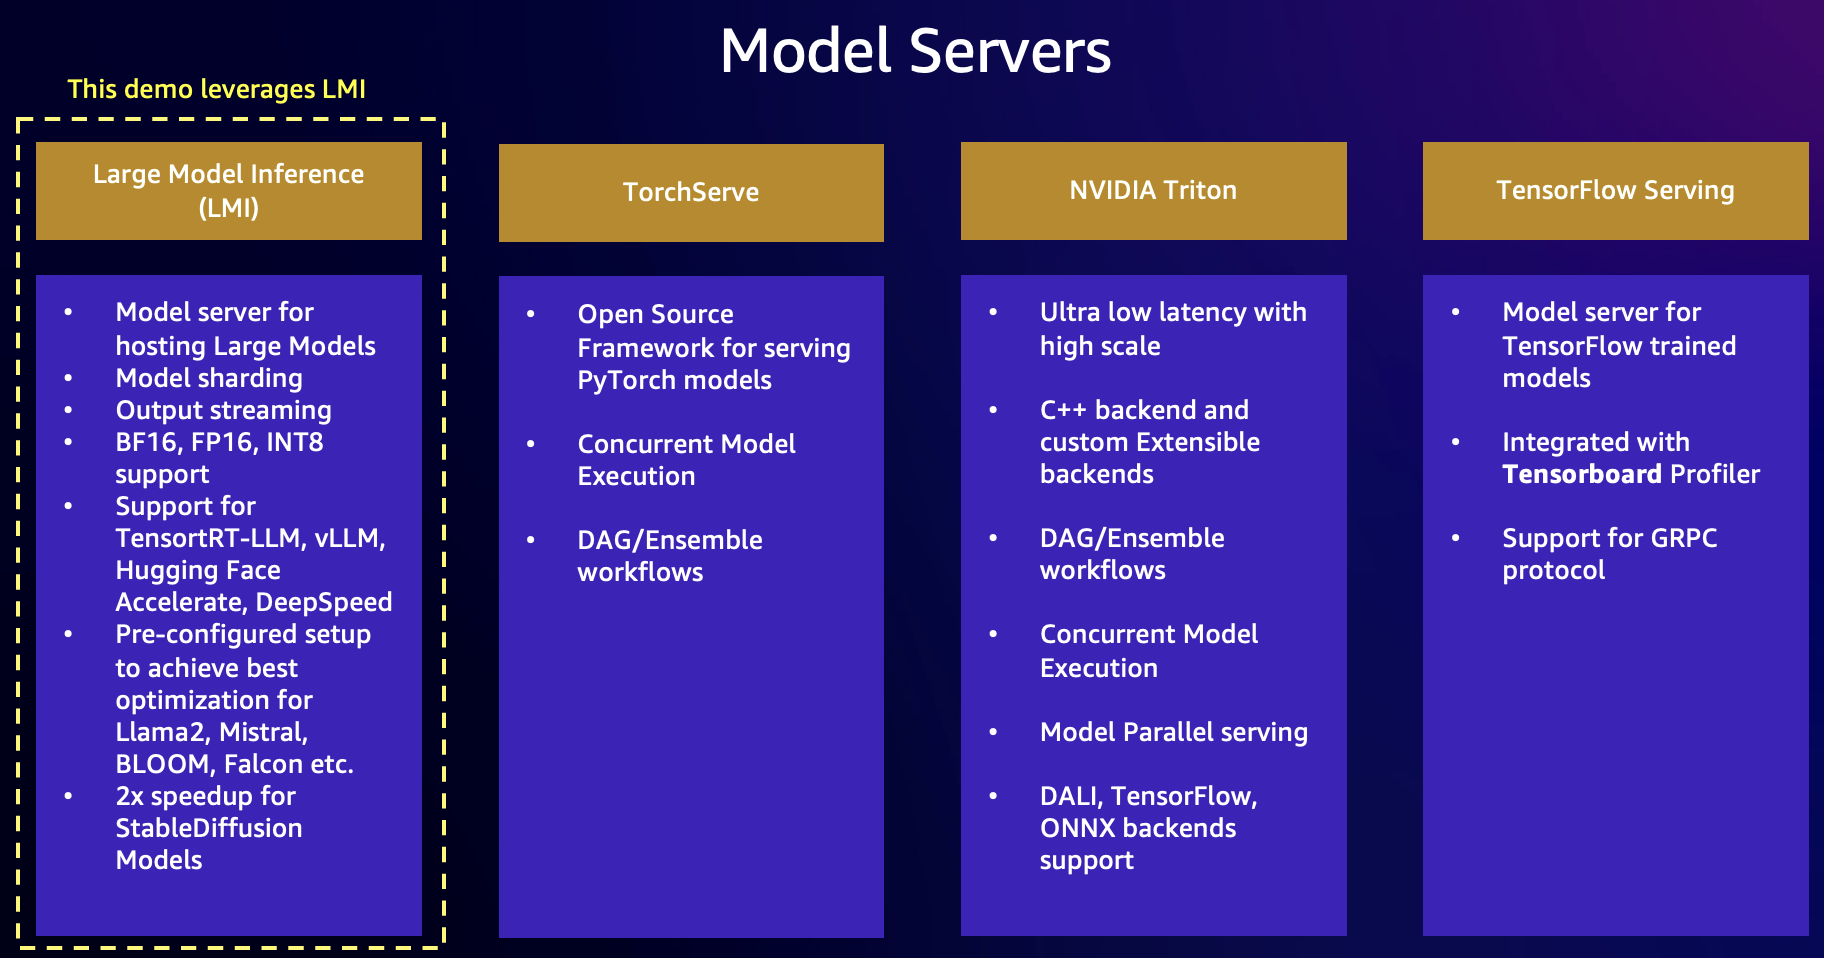

### License agreement
 - View license information https://huggingface.co/meta-llama before using the model.
 - This notebook is a sample notebook and not intended for production use. Please refer to the licence at https://github.com/aws/mit-0. 

### Install, import the required libraries; set some variables

In [1]:
!pip install sagemaker boto3 huggingface_hub awscli --upgrade --quiet

In [19]:
import sagemaker
import jinja2
#from sagemaker import image_uris
from sagemaker import Model, image_uris, serializers, deserializers
import boto3
import os
import time
import json
from pathlib import Path

#### Set IAM role, initiate SageMaker session and S3 bucket for model deployment

In [2]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [3]:
model_bucket = sess.default_bucket()  # bucket to house model artifacts
s3_code_prefix = "hf-large-model-djl/meta-llama/Llama-2-7b-fp16/code"  # folder within bucket where code artifact will go

s3_model_prefix = "hf-large-model-djl/meta-llama/Llama-2-7b-fp16/model"  # folder within bucket where model artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

To optimize the deployment of Large Language Models (LLMs); one needs to choose the appropriate model partitioning framework, optimal batching technique, batching size, tensor parallelism degree, etc. The choice of a particular configuration depends on the usecase.

Hence, based on the usecase, you need to:
1. set the configuration parameters for the container.
2. select the appropriate container image to be used for inference.

### Set the configuration parameters using environment variables
1. `SERVING_LOAD_MODELS` - specifies the engine that will be used for this workload. In this case we'll be hosting a model using the **Python** engine.

2. `OPTION_MODEL_ID`: Set this to the URI of the Amazon S3 bucket that contains the model. When this is set, the container leverages [s5cmd](https://github.com/peak/s5cmd) to download the model from s3. This enables faster deployments by utilizing optimized approach within the DJL inference container to transfer the model from S3 into the hosting instance.
If you want to download the model from huggingface.co, you can set `OPTION_MODEL_ID` to the model id of a pre-trained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co.

3. `OPTION_TENSOR_PARALLEL_DEGREE`: Set to the number of GPU devices over which DeepSpeed needs to partition the model. This parameter also controls the number of workers per model which will be started up when DJL serving runs. In this example we use the `ml.g5.12xlarge` instance that has 4 GPUs; hence this is set to 4.

4. `OPTION_ROLLING_BATCH`: This parameter enables the use of a particular batching technique for continuous or iteration level batching to enable merging multiple concurrent requests that arrive at different times for inference.
In scenarios that involves open ended generation and chatbots, there is a need for having a high throughput. [vLLM](https://arxiv.org/pdf/2309.06180.pdf) is a fast LLM inference and serving framework that uses techniques like PagedAttention and continuous batching to improve the throughput. Hence, we set the `rolling_batch` parameter to `vllm`. When using `vllm`, you can also use some [additional parameters](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md#vllm).

5. `OPTION_MAX_ROLLING_BATCH_SIZE`: The maximum number of concurrent requests to be used in a batch by the model server for inference. Clients can still send more requests to the endpoint, they will be queued.


For more information on the available options, please refer to the [DJL Serving - SageMaker Large Model Inference Configurations](https://github.com/deepjavalibrary/djl-serving/blob/master/serving/docs/lmi/configurations_large_model_inference_containers.md)


### Select the relevant Large Model Inference container
SageMaker offers optimized [large model inference containers](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers) that contains different frameworks for model parallelism enabling inference of LLMs on multiple GPUs.

In this scenario, since we are leveraging `vllm` as the batching technique, we leverage the `deepspeed` container that has frameworks like deepspeed, vllm, etc.

In [4]:
deepspeed_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", 
    region=sess.boto_session.region_name, 
    version="0.26.0"
)

env_generation = {"HUGGINGFACE_HUB_CACHE": "/tmp",
                  "TRANSFORMERS_CACHE": "/tmp",
                  "SERVING_LOAD_MODELS": "test::Python=/opt/ml/model",
                  "OPTION_MODEL_ID": "TheBloke/Llama-2-7B-Chat-fp16",
                  "OPTION_TRUST_REMOTE_CODE": "true",
                  "OPTION_TENSOR_PARALLEL_DEGREE": "max",
                  "OPTION_ROLLING_BATCH": "vllm",
                  "OPTION_MAX_ROLLING_BATCH_SIZE": "32",
                  "OPTION_DTYPE":"fp16"
                 }

### Select the appropriate inference image and configuration parameters depending on the use case.

For the purpose of the deployment we will select Chatbots. 

In [5]:
# - Select the appropriate environment variable which will tune the deployment server.
env = env_generation # use this in case it is 'generation' task 

# - now we select the appropriate container 
inference_image_uri = deepspeed_image_uri # use this in case it is 'generation' task 

print(f"Environment variables are ---- > {env}")
print(f"Image going to be used is ---- > {inference_image_uri}")

Environment variables are ---- > {'HUGGINGFACE_HUB_CACHE': '/tmp', 'TRANSFORMERS_CACHE': '/tmp', 'SERVING_LOAD_MODELS': 'test::Python=/opt/ml/model', 'OPTION_MODEL_ID': 'TheBloke/Llama-2-7B-Chat-fp16', 'OPTION_TRUST_REMOTE_CODE': 'true', 'OPTION_TENSOR_PARALLEL_DEGREE': 'max', 'OPTION_ROLLING_BATCH': 'vllm', 'OPTION_MAX_ROLLING_BATCH_SIZE': '32', 'OPTION_DTYPE': 'fp16'}
Image going to be used is ---- > 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.26.0-deepspeed0.12.6-cu121


To create the end point the steps are:
- Create the Model using the inference image container

- Create the endpoint config using the following key parameters

In this notebook we leverage the boto3 SDK. You can also use the [SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/).

### Step 1: Create the Model
Leverage the `inference_image_uri` to create a model object. We will leverage the Least routing algorithim -- [Least Routing Algorithim](https://aws.amazon.com/blogs/machine-learning/minimize-real-time-inference-latency-by-using-amazon-sagemaker-routing-strategies/). This innovation from sagemnaker has shown to reduce latency by 10% or more when we have multiple instances configured to serve the endpoints

### 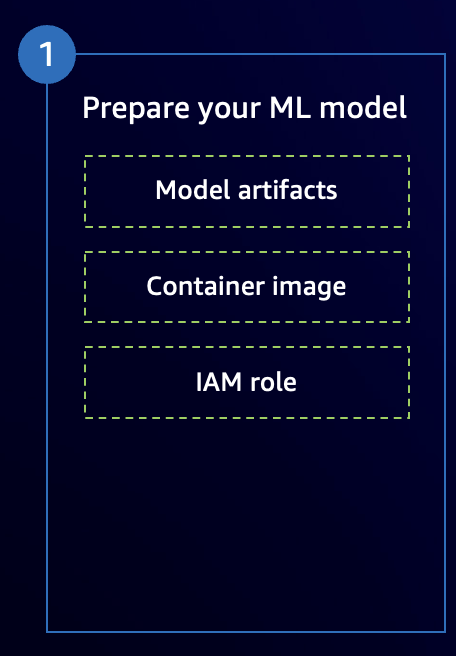

In [6]:
model_name = sagemaker.utils.name_from_base("lmi-llama2-7b")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "Environment": env,
    }
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

lmi-llama2-7b-2024-04-11-17-49-58-270
Created Model: arn:aws:sagemaker:us-west-2:015476483300:model/lmi-llama2-7b-2024-04-11-17-49-58-270


### Step 2: Create an endpoint config
Create an endpoint configuration using the appropriate instance type. Set the `ContainerStartupHealthCheckTimeoutInSeconds` to account for the time taken to download the LLM weights from S3 or the model hub; and the time taken to load the model on the GPUs.

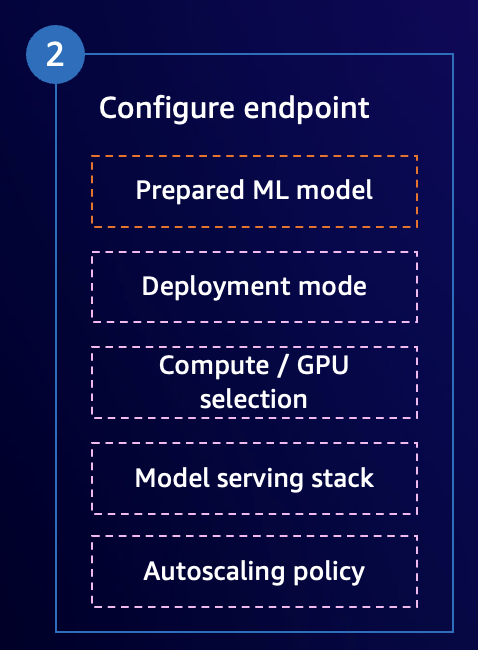

In [7]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.2xlarge",
            "InitialInstanceCount": 1,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 2400,
            "RoutingConfig": {
                'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'
            },
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:015476483300:endpoint-config/lmi-llama2-7b-2024-04-11-17-49-58-270-config',
 'ResponseMetadata': {'RequestId': 'ffb8f9f2-664c-42a5-8829-42538b7dd7df',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ffb8f9f2-664c-42a5-8829-42538b7dd7df',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '125',
   'date': 'Thu, 11 Apr 2024 17:50:00 GMT'},
  'RetryAttempts': 0}}

### Step 3: Create an endpoint using the model and endpoint config

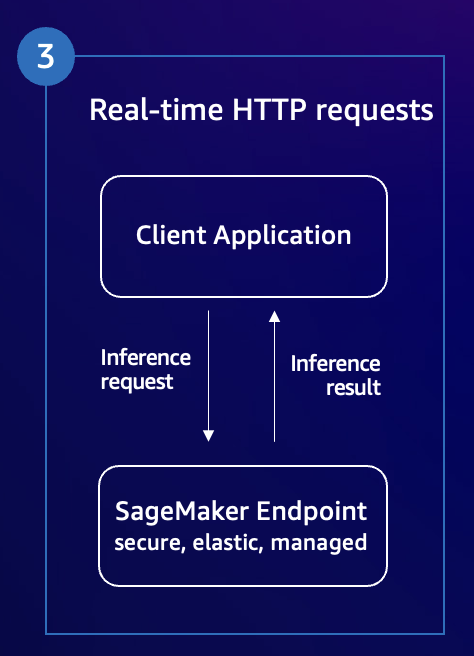

In [8]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-west-2:015476483300:endpoint/lmi-llama2-7b-2024-04-11-17-49-58-270-endpoint


#### This step can take ~15 mins or longer

In [9]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:015476483300:endpoint/lmi-llama2-7b-2024-04-11-17-49-58-270-endpoint
Status: InService


### Option 1: Invoke SageMaker EndPoint using Python SDK - Data Scientist (Usability and Abstraction)

In [24]:
# Use this for Chatbot or QA or open ended generation task
prompt = "what does Amazon.com offers?"
params = { "max_new_tokens": 100,"do_sample": False }

In [20]:
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
)

In [31]:
# inference via sagemaker python SDK
predictor.predict(
    {"inputs": prompt, "parameters": params})

b'{"generated_text": "\\nAmazon.com is a multinational technology company that offers various products and services through its platform. Here are some of the things Amazon.com offers:\\n1. Online Shopping: Amazon.com is primarily known for its e-commerce platform, where customers can buy products from millions of sellers in categories such as electronics, books, clothing, home goods, and more.\\n2. AmazonBasics: AmazonBasics is Amazon\xe2\x80\x99s own brand of products"}'

### Option 2: Invoke SageMaker EndPoint using boto3 - MLOps Engineer - Language fLexibility, Low level constructs

In [32]:
response_model = smr_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json.dumps(
        {
            "inputs": prompt,
            "parameters": params
        }
    ),
    ContentType="application/json",
)

response_model["Body"].read().decode("utf8")

'{"generated_text": "\\nAmazon.com offers a wide range of products, services, and features, including:\\n\\n1. Online Shopping: Amazon.com is primarily an e-commerce platform where customers can shop for a wide variety of products, including electronics, books, clothing, home goods, beauty products, and more.\\n\\n2. Amazon Prime: Amazon offers a membership program called Amazon Prime, which provides customers with exclusive benefits such as free two-day shipping, streaming of"}'

### Option 3: Invoke SageMaker EndPoint using Postman - Application Developers

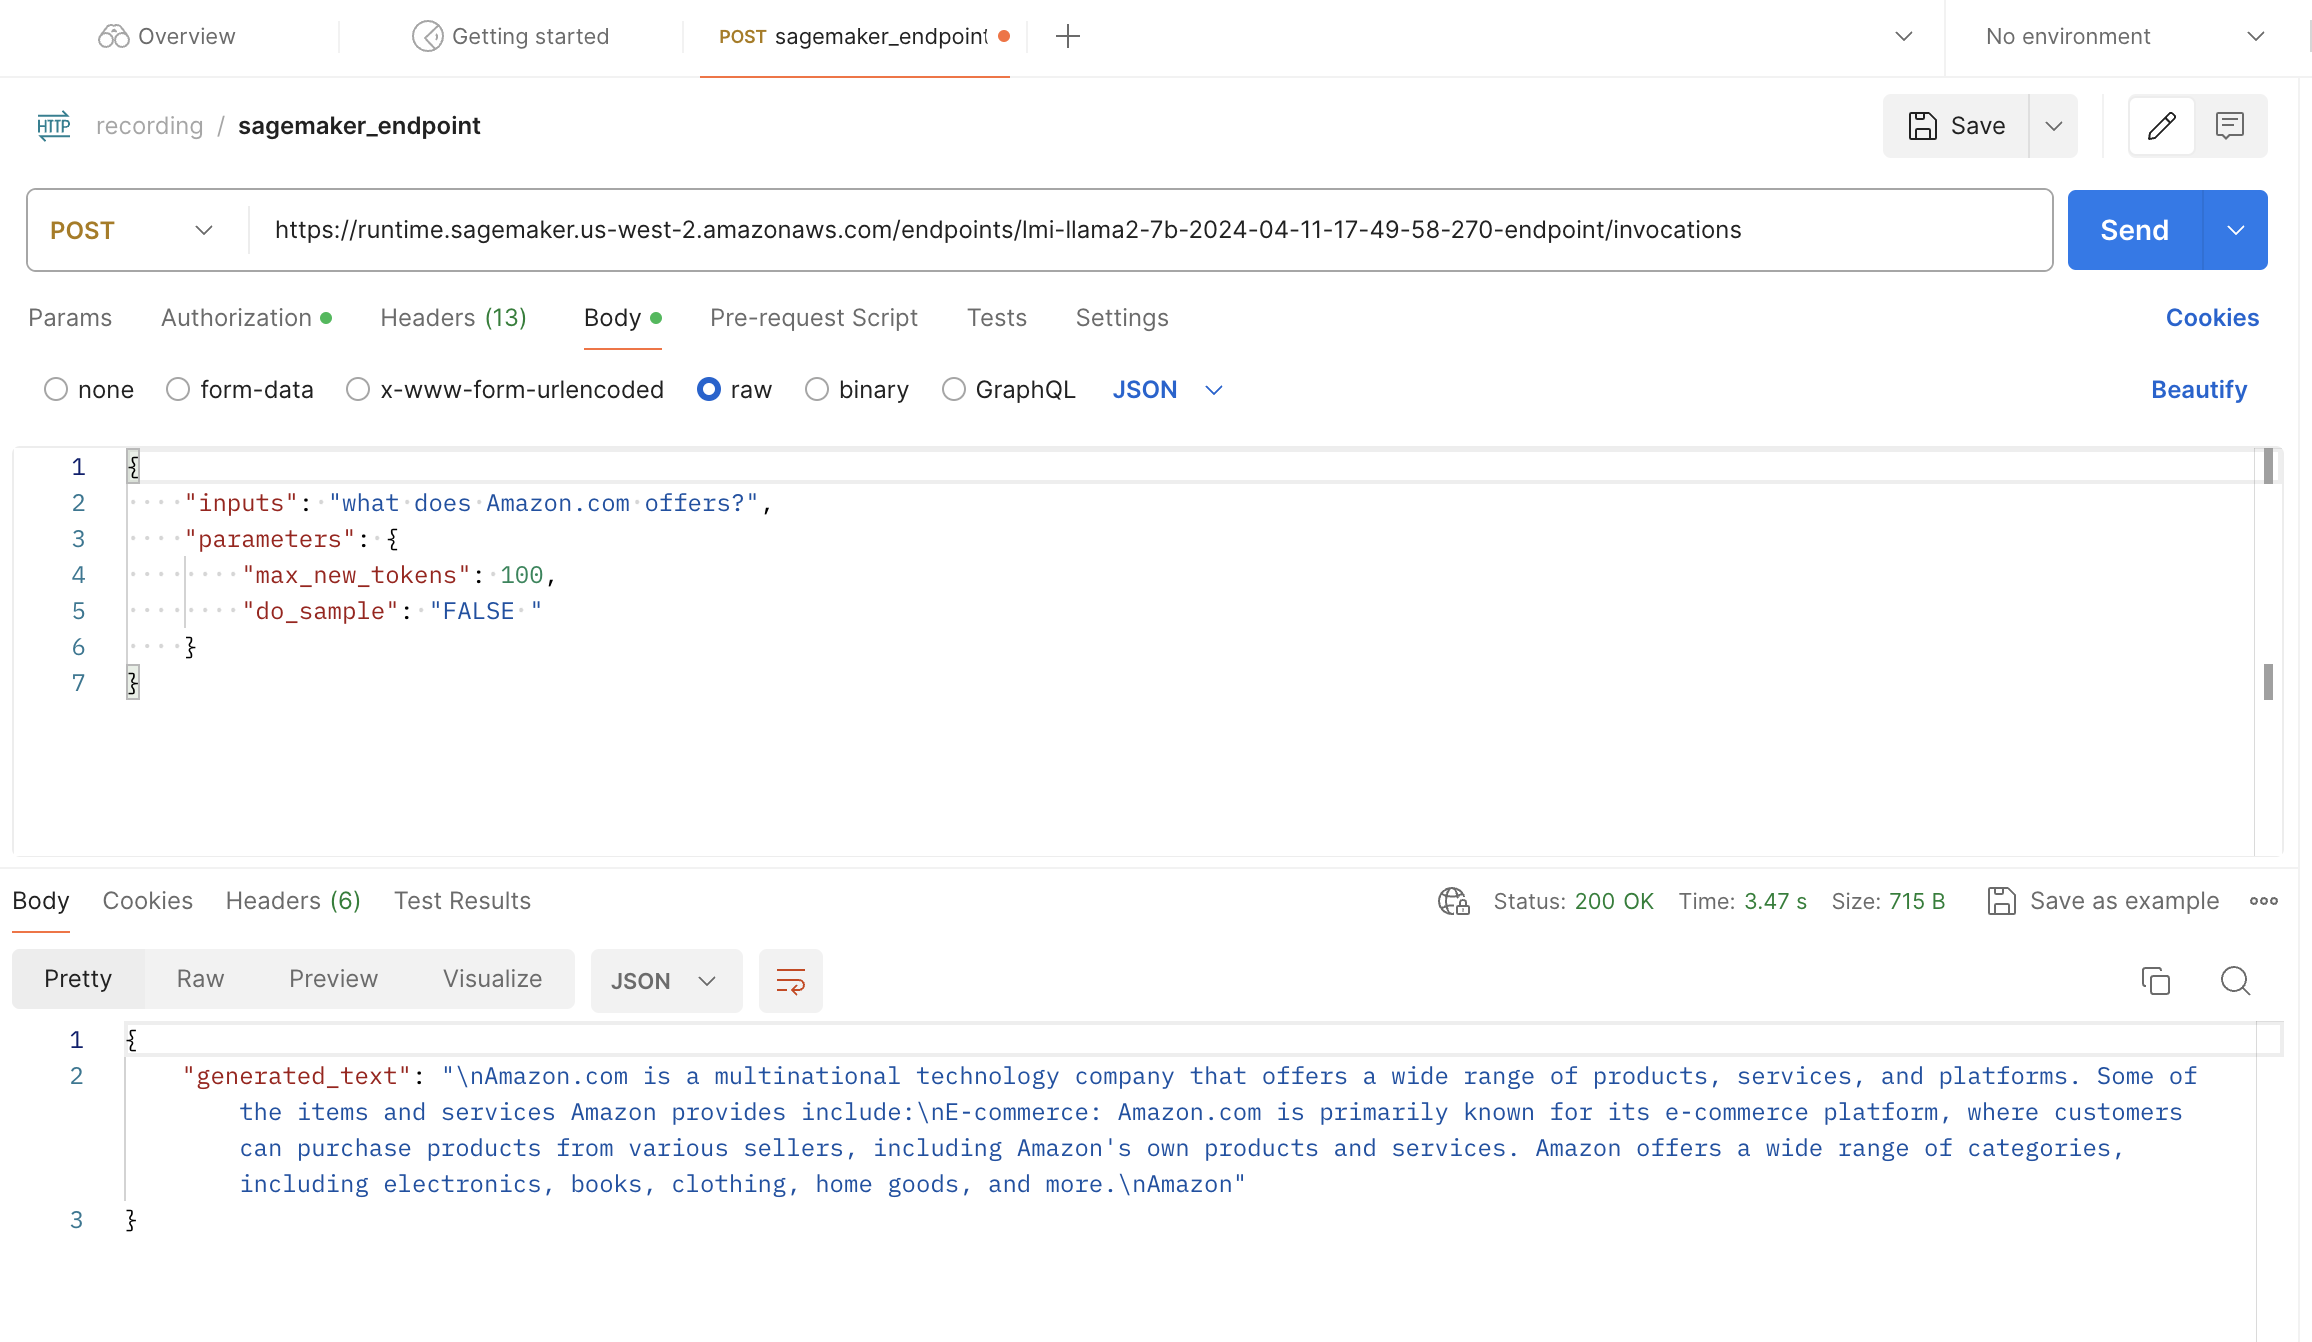

## Take Aways. Use 3 APIs to deploy your model

LMI Containers - Access state-of-the-art tooling to optimize large language models (LLMs) on SageMaker and achieve price-performance benefits

Deploy the model on Amazon SageMaker with 3 simple apis:

1. create_model
2. create_endpoint_config
3. create_endpoint

Invoke the model using Phython SDK, boto3 or Postman using invoke_endpoint api 

## Clean up the environment

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)

#### Resource:
- [Deep Learning containers for large model inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-dlc.html)
- [Deep Java Library for Large Model Inference](https://docs.djl.ai/docs/serving/serving/docs/large_model_inference.html)